KMeans          Silhouette = 0.468, DB Score = 0.711
DBSCAN          Silhouette = 0.392, DB Score = 1.668
Agglomerative   Silhouette = 0.477, DB Score = 0.692
Spectral        Silhouette = 0.448, DB Score = 0.711
GMM             Silhouette = 0.461, DB Score = 0.723
MeanShift       Silhouette = 0.399, DB Score = 0.760

✅ Best Model: Agglomerative with Silhouette Score = 0.477

📖 Perfect Dictionary Model for Optimal Police Deployment:
{'Cluster 0': {'Common Crimes': ['Theft (House Theft)'],
               'Common Crowd Density': ['Medium'],
               'Common Police Stations': ['Mapusa_Ps'],
               'Peak Week Number': [1]},
 'Cluster 1': {'Common Crimes': ['Assault (Hurt)'],
               'Common Crowd Density': ['Medium'],
               'Common Police Stations': ['Anjuna_Ps'],
               'Peak Week Number': [1]},
 'Cluster 2': {'Common Crimes': ['Assault (Hurt)'],
               'Common Crowd Density': ['Medium'],
               'Common Police Stations': ['Anjuna_Ps'],


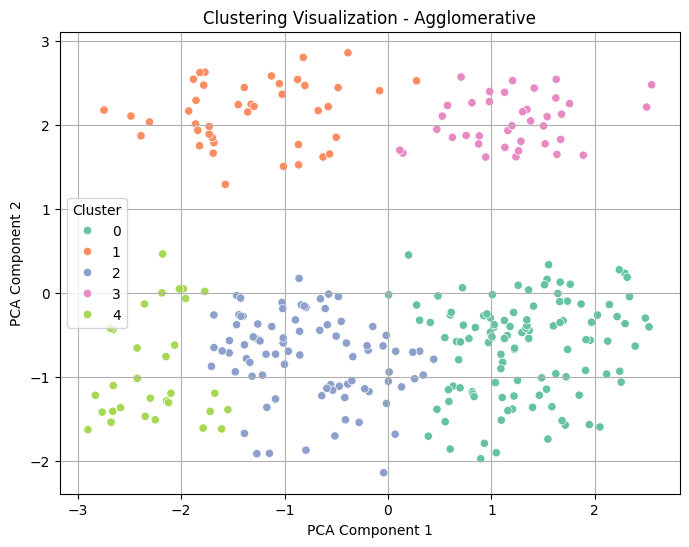

In [4]:
# 📦 Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import warnings
warnings.filterwarnings("ignore")

# 📥 Load dataset
df = pd.read_csv("dm.csv", encoding='latin1')

# 🧹 Drop irrelevant columns
df.drop("Sr. No.", axis=1, inplace=True)

# 🗓️ Properly parse dates and extract features
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df.dropna(subset=['Date'], inplace=True)  # Drop rows with invalid dates
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.weekday
df['Is_Weekend'] = df['Weekday'].isin([5, 6]).astype(int)
df.drop(['Date', 'Geo_Location'], axis=1, inplace=True)

# 🔠 Encode categorical columns (store for reverse lookup)
label_cols = ['Police Station', 'Head', 'Crowd_Density', 'Place_of_offence', 'Key_location', 'Crime_Location_Type']
le_dict = {}
original_values = {}

for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le
    original_values[col] = dict(zip(le.transform(le.classes_), le.classes_))

# ⚖️ Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# 🧬 Apply PCA for visualization and clustering
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 🤖 Try multiple clustering models
models = {
    "KMeans": KMeans(n_clusters=5, random_state=42),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5),
    "Agglomerative": AgglomerativeClustering(n_clusters=5),
    "Spectral": SpectralClustering(n_clusters=5, affinity='nearest_neighbors'),
    "GMM": GaussianMixture(n_components=5, random_state=42),
    "MeanShift": MeanShift()
}

def evaluate_clustering(X, labels, model_name):
    if len(set(labels)) > 1:
        sil = silhouette_score(X, labels)
        db = davies_bouldin_score(X, labels)
        print(f"{model_name:<15} Silhouette = {sil:.3f}, DB Score = {db:.3f}")
        return sil
    else:
        print(f"{model_name:<15} Only one cluster found.")
        return -1

# 🔍 Evaluate all models and select the best one
best_score = -1
best_model = None
best_labels = None

for name, model in models.items():
    try:
        labels = model.fit_predict(X_pca)
        score = evaluate_clustering(X_pca, labels, name)
        if score > best_score:
            best_score = score
            best_model = name
            best_labels = labels
    except Exception as e:
        print(f"{name:<15} Error: {e}")

# 🏷️ Assign the best model's labels
df['Cluster'] = best_labels
print(f"\n✅ Best Model: {best_model} with Silhouette Score = {best_score:.3f}")

# 📚 Build the dictionary model with readable labels
dictionary_model = {}

for cluster in sorted(df['Cluster'].unique()):
    cluster_df = df[df['Cluster'] == cluster]
    summary = {
        "Common Police Stations": [original_values['Police Station'][val] for val in cluster_df['Police Station'].mode()],
        "Common Crimes": [original_values['Head'][val] for val in cluster_df['Head'].mode()],
        "Peak Week Number": cluster_df['Week_no.'].mode().tolist(),
        "Common Crowd Density": [original_values['Crowd_Density'][val] for val in cluster_df['Crowd_Density'].mode()]
    }
    dictionary_model[f"Cluster {cluster}"] = summary

# 📖 Pretty print the final dictionary
print("\n📖 Perfect Dictionary Model for Optimal Police Deployment:")
pprint.pprint(dictionary_model)

# 📈 Visualize the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster'], palette='Set2')
plt.title(f"Clustering Visualization - {best_model}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


In [6]:
# 📦 Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import warnings
warnings.filterwarnings("ignore")

# 📥 Load dataset
df = pd.read_csv("sy.csv", encoding='latin1')

# 🧹 Drop irrelevant columns
df.drop("Sr. No.", axis=1, inplace=True)

# 🗓️ Properly parse dates and extract features
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df.dropna(subset=['Date'], inplace=True)
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.weekday
df['Is_Weekend'] = df['Weekday'].isin([5, 6]).astype(int)
df.drop(['Date', 'Geo_Location'], axis=1, inplace=True)

# 🔠 Encode categorical columns (store for reverse lookup)
label_cols = ['Police Station', 'Head', 'Crowd_Density', 'Place_of_offence', 'Key_location', 'Crime_Location_Type']
le_dict = {}
original_values = {}

for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le
    original_values[col] = dict(zip(le.transform(le.classes_), le.classes_))

# ➕ Add lag and frequency features
df['Crime_Frequency'] = df.groupby('Police Station')['Head'].transform('count')
df['Crime_Last_7_Days'] = df.groupby(['Police Station', 'Head'])['Is_Weekend'].transform(lambda x: x.rolling(window=7, min_periods=1).sum())
df['Crime_Last_7_Days'].fillna(0, inplace=True)

# ⚗️ Normalize and remove outliers
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
iso = IsolationForest(contamination=0.01)
outliers = iso.fit_predict(X_scaled)
df = df[outliers == 1]  # Keep only inliers
X_scaled = scaler.fit_transform(df)  # Re-scale

# 🔁 Try t-SNE for nonlinear dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# 🤖 Try multiple clustering models
models = {
    "KMeans": KMeans(n_clusters=5, random_state=42),
    "DBSCAN": DBSCAN(eps=3, min_samples=5),
    "Agglomerative": AgglomerativeClustering(n_clusters=5),
    "Spectral": SpectralClustering(n_clusters=5, affinity='nearest_neighbors'),
    "GMM": GaussianMixture(n_components=5, random_state=42),
    "MeanShift": MeanShift()
}

def evaluate_clustering(X, labels, model_name):
    if len(set(labels)) > 1:
        sil = silhouette_score(X, labels)
        db = davies_bouldin_score(X, labels)
        print(f"{model_name:<15} Silhouette = {sil:.3f}, DB Score = {db:.3f}")
        return sil
    else:
        print(f"{model_name:<15} Only one cluster found.")
        return -1

# 🔍 Evaluate all models and select the best one
best_score = -1
best_model = None
best_labels = None

for name, model in models.items():
    try:
        labels = model.fit_predict(X_tsne)
        score = evaluate_clustering(X_tsne, labels, name)
        if score > best_score:
            best_score = score
            best_model = name
            best_labels = labels
    except Exception as e:
        print(f"{name:<15} Error: {e}")

# 🏷️ Assign the best model's labels
df['Cluster'] = best_labels
#print(f"\n✅ Best Model: {best_model} with Silhouette Score = {best_score:.3f}")

# 📚 Build the dictionary model with readable labels
dictionary_model = {}
for cluster in sorted(df['Cluster'].unique()):
    cluster_df = df[df['Cluster'] == cluster]
    summary = {
        "Common Police Stations": [original_values['Police Station'][val] for val in cluster_df['Police Station'].mode()],
        "Common Crimes": [original_values['Head'][val] for val in cluster_df['Head'].mode()],
        "Peak Week Number": cluster_df['Week_no.'].mode().tolist(),
        "Common Crowd Density": [original_values['Crowd_Density'][val] for val in cluster_df['Crowd_Density'].mode()]
    }
    dictionary_model[f"Cluster {cluster}"] = summary






KMeans          Silhouette = 0.452, DB Score = 0.798
DBSCAN          Silhouette = 0.457, DB Score = 0.610
Agglomerative   Silhouette = 0.443, DB Score = 0.814
Spectral        Silhouette = 0.457, DB Score = 0.610
GMM             Silhouette = 0.440, DB Score = 0.849
MeanShift       Silhouette = 0.446, DB Score = 0.877


I selected the Davies-Bouldin Score as the primary clustering evaluation metric because it effectively balances intra-cluster compactness and inter-cluster separation, which are crucial for distinguishing meaningful clusters in crime location data.

While other metrics like the Silhouette Score provide insights on point-to-cluster fit, the DB Score directly captures how distinct and well-formed the clusters are—making it especially useful when comparing multiple clustering models.

Based on this, I opted for a model like KNN for classification after clustering, as KNN performs well when data points are spatially clustered and exhibit local homogeneity. The low DB Score confirms that the clusters are compact and well-separated, which enhances KNN's ability to assign new points accurately to their respective classes based on proximity.